# **Metropolis-Hastings code for inferring the slope and latent variable (true x).**



**Data**: ($\hat x$, $\hat y$)  Data point.

**Model**: $y=mx$, and $x$ and $y$ have independent gaussian errors of unit variance.

**Parameters**: $m$, $x$ (latent)

**Likelihood function**: BHM - see notes

Alan Heavens 2022

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Colab doesn't have corner package installed, so install it (if you run locally, you can install separately):

!pip install corner
import corner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Read in LHC data, as pairs of (Energy, counts), and plot:

In [2]:
# Data:

xhat = 10
yhat = 15

Define the log(target) function; it is not normalised:

In [3]:
def lntarget(m,x):
  # Don't bother to normalise - just adds a constant
  lntarget = -(xhat-x)**2/2-(yhat-m*x)**2/2
  return lntarget

Now we start the MCMC section.

In [4]:
# Choose a random starting point for x (between 0 and 10), and m (between -1 and -8):

x0 = np.random.uniform(5,20)
m0 = np.random.uniform(-1,2)

Define a simple proposal distribution (uniform distribution, with offset between (-Dx/2, Dx/2) and (-Dm/2,Dm/2).  

Size of proposal distribution is set by Dx and Dm

New point depends only on the previous point (which makes it a Markov process).

In [5]:
def x_prop(x,Dx):
  return np.random.uniform(x-Dx/2,x+Dx/2)

def m_prop(m,Dm):
  return np.random.uniform(m-Dm/2,m+Dm/2)

In [20]:
# Number of samples to produce (1000 is good to see the trace plots and burnin; 
# use many more to get a good 2D posterior with corner.py)

Nsamples = 10000

# Set the proposal size (uniform in 2D).  Experiment with these and see what the trace plots look
# like, and how they affect the acceptance rate

Dx = 10
Dm = 10

Start the loop to generate samples.   This is the core of the code.

In [21]:
# Declare some 1D arrays to store the sample values:

xSamples    = np.zeros(Nsamples)
mSamples    = np.zeros(Nsamples)
logLikelihood   = np.zeros(Nsamples)

# Keep a counter of aceptances to record the acceptance rate:

accepted        = 1

# Initialise with the random starting point found earlier:

xSamples[0] = x0
mSamples[0] = m0

logLikelihood[0] = lntarget(m0,x0)

# Main loop, generating samples with the accept/reject Metropolis algorithm:

for s in range(1,Nsamples):

# Generate candidate proposed new sample:

  x_proposed = x_prop(xSamples[s-1],Dx)
  m_proposed = m_prop(mSamples[s-1],Dm)



# Compute the log likelihood of the proposed point:

  logLikelihood_proposed = lntarget(m_proposed, x_proposed)

# Accept or reject the new point using the Metropolis algorithm:

# Accept definitely if likelihood goes up:

  if(logLikelihood_proposed > logLikelihood[s-1]):

    xSamples[s]  = x_proposed
    mSamples[s]  = m_proposed
    logLikelihood[s] = logLikelihood_proposed
    accepted         = accepted + 1

# Accept with a certain probability if the likelihood goes down.
# It is convenient to take logs of the Metropolis condition:

  else:
    rand = np.log(np.random.uniform(0,1))
    if(rand < logLikelihood_proposed-logLikelihood[s-1]):

      xSamples[s]  = x_proposed
      mSamples[s]  = m_proposed
      logLikelihood[s] = logLikelihood_proposed
      accepted         = accepted + 1

    else:
# Reject. 
# In this case, the Metropolis requires the last point to be repeated in the chain:

      xSamples[s]  = xSamples[s-1]
      mSamples[s]  = mSamples[s-1]
      logLikelihood[s] = logLikelihood[s-1]


Plot trace plots for the parameters $x$, $m$:

Text(0, 0.5, '$x$')

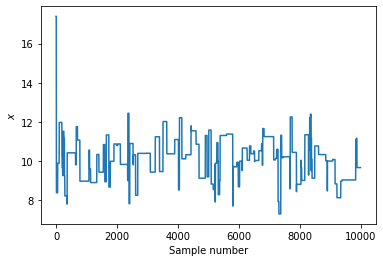

In [22]:
plt.plot(xSamples)
plt.xlabel('Sample number')
plt.ylabel(r"$x$")

Text(0, 0.5, '$m$')

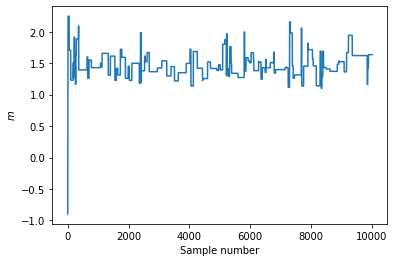

In [23]:
plt.plot(mSamples)
plt.xlabel('Sample number')
plt.ylabel(r"$m$")

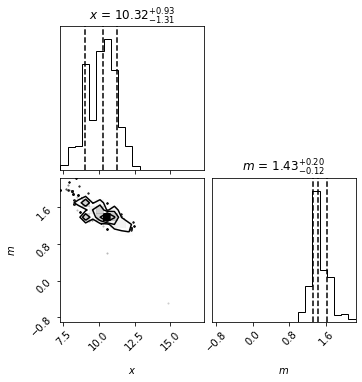

In [24]:
# Use corner.py to plot joint posterior for x and m, and 1D marginal distributions.
# It also calculates the mean and r.m.s.

# First put samples in a 2D array for corner.py

samples = np.zeros((Nsamples,2))
samples[:,0]=xSamples
samples[:,1]=mSamples

figure = corner.corner(samples,labels=[r"$x$",r"$m$"],
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 12})

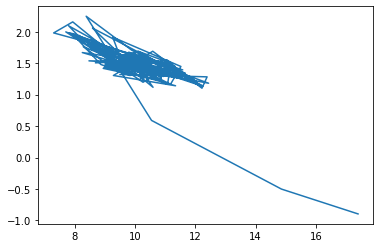

In [25]:
plt.plot(samples[:,0],samples[:,1])

In [26]:
print('Acceptance rate =',accepted/Nsamples)

Acceptance rate = 0.0132
